In [1]:
# go wide screen

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
def pp(s):
    print(s)
    return s + "\n"

# Datamodel for the flow network

In [4]:
# Add current working directory to pythonpath
import sys
sys.path.append("/Users/mxhf/ownCloudRZG/work/MPE/pfs/ETS/real_test")

# Next two lines forc outomatic reload of loaded module. Convenient if
# one is still fiddeling with them.
%load_ext autoreload
%autoreload 2

import pfs_netflow.datamodel as dm

# Read the catalogs, compute visibility ... 

In [5]:
#BLOCKLENGTH = 300. # block exposure time in s, to simulate three consequtive exposures
BLOCKLENGTH = 900. # block exposure time in s

In [6]:
from astropy.io import ascii
import numpy as np


# Define target lists.
fscience_targets = "../../ETS/pfs_target_list/pfs_preliminary_target_cosmology.dat"
fcal_stars       = "../../ETS/pfs_target_list/pfs_preliminary_target_cosmology_fcstars.dat"
fsky_pos         = "../../ETS/pfs_target_list/pfs_preliminary_target_cosmology_sky.dat"

# Load target lists.
science_targets = ascii.read(fscience_targets)

cal_stars = ascii.read(fcal_stars)

sky_pos = ascii.read(fsky_pos)

# Conversion of column names, this should not be necessary anymore in future versions.
for t in [science_targets, cal_stars, sky_pos]:
    t['R'].name = 'RA'
    t['Dec'].name = 'DEC'
    t['Exposure'].name = 'EXP_TIME'
    
 
cRA  = np.median( science_targets['RA'] )  
cDEC =  np.median( science_targets['DEC'] ) 
RAmin,RAmax   = np.min( science_targets['RA'] ), np.max( science_targets['RA'] )
DECmin,DECmax = np.min( science_targets['DEC'] ), np.max( science_targets['DEC'] )


In [7]:
# Convert data to lists for ETS.
import numpy as np
from numpy import hstack
from numpy import cos, deg2rad, sqrt
from numpy import unique, array
from collections import OrderedDict


ID         = hstack([science_targets['ID'],cal_stars['ID'],sky_pos['ID']])
ra         = hstack([science_targets['RA'],cal_stars['RA'],sky_pos['RA']])
dec        = hstack([science_targets['DEC'],cal_stars['DEC'],sky_pos['DEC']])
exp_times  = hstack([science_targets['EXP_TIME'],cal_stars['EXP_TIME'],sky_pos['EXP_TIME']])
priorities = hstack([science_targets['Priority'],cal_stars['Priority'],sky_pos['Priority']])

# make up target classes from target type and priority
types = ["sci"]*len(science_targets) + ["cal"]*len(cal_stars) + ["sky"]*len(sky_pos)
class_dict = {}
for id,t,p in zip(ID, types, priorities):
    class_dict[id] = '{}_P{:02d}'.format(t, p)
    
#Define dither pattern
DITHER_PATTERN = OrderedDict()
DITHER_PATTERN['A'] = ( 10./3600.,0.)
DITHER_PATTERN['B'] = (-10./3600.,0.)

pointings = OrderedDict()
for did, (offset_ra, offset_dec) in DITHER_PATTERN.items():
    pointing_RA, pointing_DEC = cRA + offset_ra, cDEC + offset_dec
    pointings[did] = (pointing_RA, pointing_DEC) 

# limit targets to a smaller field of view
DRMAX_SQ = (2700./3600.)**2.

#DRMAX_SQ = (200./3600.)**2.

dra = (ra - cRA)*cos(deg2rad(cDEC))
ddec = dec - cDEC
ii = (dra**2. + ddec **2.) <= DRMAX_SQ

ID = ID[ii].tolist()
ra = ra[ii].tolist()
dec = dec[ii].tolist()
exp_times = exp_times[ii].tolist()
priorities = priorities[ii].tolist()
types = np.array(types)[ii].tolist()

c = np.array([ class_dict[t][:3] for t in ID ])
ii_sci = c == 'sci'
ii_cal = c == 'cal'
ii_sky = c == 'sky'

print( "{} science targets, {} calibration targets, and {} sky positions survive radial cut.".format(sum(ii_sci),sum(ii_cal),sum(ii_sky)))

12531 science targets, 20 calibration targets, and 567 sky positions survive radial cut.


In [8]:
# assign random priorities between 1 and 3 for the  science targets
if False:
    # Kohei's catalog already does come with priorities
    from numpy import random
    from numpy import array

    random.seed(42)

    N =  sum(ii_sci) 

    newpri = array( random.uniform(1.,4., size=N) , dtype=int)
    priorities = np.array(priorities)

    priorities[ii_sci] = newpri
    priorities = priorities.tolist()

In [9]:
# compute number of required visists from exposure times
# and block length
nreqv_dict = {}
for id,t,nrv in zip(ID, types, array(exp_times)/BLOCKLENGTH):
    nreqv_dict[id] = max( int(nrv), 1)
    
print( "Required revisits", unique( [v for v in nreqv_dict.values()] ))

Required revisits [1]


In [10]:
# RANDOMISE NUMBER OF REQUIRED VISISTS
RANDOMIZENREQ = False

if RANDOMIZENREQ:
    from numpy import random
    
    NVISITS = 10
    nv = np.floor( random.uniform(NVISITS+1, size=len(ID)) ) 

    # compute number of required visists from exposure times
    # and block length
    nreqv_dict = {}
    for id,t,nrv in zip(ID, types, nv):
        nreqv_dict[id] = int(nrv)

    print( "Required revisits", unique( [v for v in nreqv_dict.values()] ))

In [11]:
#sys.path.append("/Users/mxhf/ownCloudRZG/work/MPE/pfs/src/ets_fiber_assigner")

import pyETS
import pycconv

# Temporary, very crude method to convert Ra/Dec pairs to x/y coordinates
# on the focal plane. To be replaced by the official functionality once
# available.
# All input angles are expected in degrees.
def radec2pos(ras, decs, raTel=None, decTel=None, posang=0.,
              time="2016-04-03T08:00:00Z"):
    if raTel is None:
        raTel = np.average(ras)
    if decTel is None:
        decTel = np.average(decs)
    return pycconv.cconv(ras,decs,raTel,decTel,posang+90.,time)

# get a data structure containing the idealized cobras
ets_cobras = pyETS.getAllCobras()

# for every pointing, compute target positions
# in the focal plane 
# and a visibilty map
visibility_maps = OrderedDict()
ets_target_pos  = OrderedDict()
for pid,(pointing_RA,pointing_DEC) in pointings.items():
    # Parse a target file and return the quantities of interest
    ets_target_pos[pid] = radec2pos(ra, dec, raTel=pointing_RA, decTel=pointing_DEC)

    # get a list of targets, and a list of Cobras that can observe them
    # keys contain object index
    # values contain indices of cobras that can observe that object.
    visibility_maps[pid] = pyETS.getVis(ets_target_pos[pid], ets_cobras)

In [12]:
#Interface to the new ETS, convert cobras, visibilities and targets to old style format
from collections import OrderedDict

# obtain cobra centers in old ETS dictionary style
cobras = OrderedDict()
for i,c in enumerate(ets_cobras):
        x,y = np.real( ets_cobras[i][0] ), np.imag( ets_cobras[i][0] )
        cobras["{:d}".format(i)] = [x,y]
        
# obtain dot centers in dictionary style
dots = OrderedDict()
for i,c in enumerate(ets_cobras):
        x,y = np.real( ets_cobras[i][-2] ), np.imag( ets_cobras[i][-2] )
        r = ets_cobras[i][-1]
        dots["{:d}".format(i)] = [x,y,r]


# obtain target positions in old ETS dictionary style
target_fplane_pos = OrderedDict()
for pid in ets_target_pos:
    tt = OrderedDict()
    for j,c in enumerate(ets_target_pos[pid]):
            x,y = np.real(c),np.imag(c)
            tt[ID[j]] = [float(x),float(y)]
    target_fplane_pos[pid] = tt

# obtain visibilities in old ETS dictionary style
visibilities = OrderedDict()
for pid in visibility_maps:
    vv = OrderedDict()   
    for v in visibility_maps[pid]:
        t = ID[v]
        cc = ["{:d}".format(c) for c in visibility_maps[pid][v]]
        vv[t] = cc
    visibilities[pid] = vv    

In [13]:
def filterFoV(xx,yy, maxx=20., maxy=20.):
    ii  = xx >= -maxx
    ii *= xx <=  maxx
    ii *= yy >= -maxy
    ii *= yy <=  maxy
    return ii

def my_circle_scatter(axes, x_array, y_array, radius, **kwargs):
    for x, y, r in zip(x_array, y_array, radius):
        circle = plt.Circle((x,y), radius=r, edgecolor='k', facecolor='grey', **kwargs)
        axes.add_patch(circle)
    return True

def plotFP(cobras,dots,targets,maxx=20.,maxy=20.):
    
    f = plt.figure(figsize=[10,10])
    ax = plt.subplot(1,1,1)
    
    # rearrange dot and cobra information for easy plotting
    dxx = np.array( [d[0] for did, d in dots.items()] )
    dyy = np.array( [d[1] for did, d in dots.items()] )
    drr = np.array( [d[2] for did, d in dots.items()] )
    ciddd = np.array( [did for did, d in dots.items()] )

    cxx = np.array( [c[0] for cid, c in cobras.items()] )
    cyy = np.array( [c[1] for cid, c in cobras.items()] )
    ciddd = np.array( [cid for cid, t in cobras.items()] )
    
    # plot cobras
    ii = filterFoV(cxx,cyy,maxx=maxx,maxy=maxy)
    plt.plot(cxx[ii],cyy[ii],'.', c='orange')
    ii = filterFoV(cxx,cyy )
    for x,y,l in zip(cxx[ii],cyy[ii],ciddd[ii]):
        plt.text(x,y,l)

    # plot dots
    ii = filterFoV(dxx,dyy,maxx=maxx,maxy=maxy)
    my_circle_scatter(ax, dxx[ii],dyy[ii], drr[ii] )
    

    N = len(target_fplane_pos)
    for i,pid in enumerate(target_fplane_pos):
        alpha = 1. - float(i)/float( N )

        # rearrange target information for easy plotting
        txx = np.array( [t[0] for tid, t in target_fplane_pos[pid].items()] )
        tyy = np.array( [t[1] for tid, t in target_fplane_pos[pid].items()] )
        tiddd = np.array( [tid for tid, t in target_fplane_pos[pid].items()] )

        # plot targets
        ii = filterFoV(txx,tyy,maxx=maxx,maxy=maxy)
        plt.plot(txx[ii],tyy[ii],'bo', alpha=alpha, label='pointing {}'.format(pid))

        for x,y,l in zip(txx[ii],tyy[ii],tiddd[ii]):
            plt.text(x,y,l, size=8)

        # plot visibility arcs
        if True:
            for tid,cc in visibilities[pid].items():
                tx,ty = target_fplane_pos[pid][tid]
                for c in cc:
                    cx,cy = cobras[c]
                    #print c
                    #plt.text(cx,cy,"{}".format(c) )
                    plt.plot([cx,tx],[cy,ty],'k-', alpha=alpha)


        
            
       #plt.text(zip(txx[ii],tyy[ii]),tiddd[ii], size=6)   

    plt.axis('equal')
    plt.xlim([-maxx,maxx])
    plt.ylim([-maxy,maxy])
    plt.legend()
    
    plt.xlabel("x [mm]")
    plt.ylabel("y [mm]")
    
#plotFP(cobras,dots,target_fplane_pos,maxx=20.,maxy=20.)

In [14]:
# Assign targetclass labels according to target type and priority
from numpy import unique

## Build array that holds class descriptor string for each target.
## This is needed later because ETS does not preserve the order.
#tclasses =   np.array( [class_dict[t] for t in targets] )
#print(unique(tclasses))

# Build dict that holds required number of visits each target.
nreqvisits = [nreqv_dict[t] for t in ID]

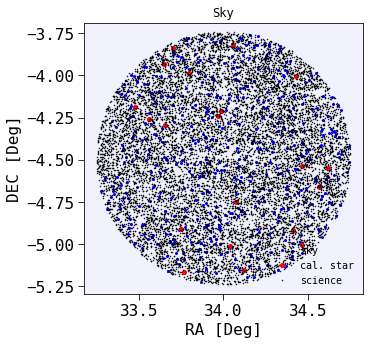

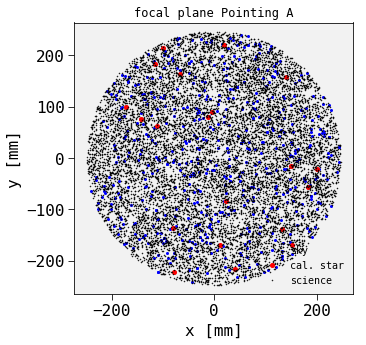

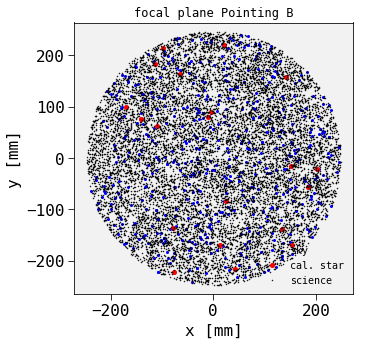

In [15]:
# plot targets on sky
f = plt.figure(figsize=[5,5])
plt.title("Sky")
ax = plt.subplot(111)
ax.set_facecolor((.95,.95,1.))
plt.plot(np.array(ra)[ii_sky],np.array(dec)[ii_sky],'b.' , label='sky', ms=4)
plt.plot(np.array(ra)[ii_cal],np.array(dec)[ii_cal],'ro' , label='cal. star', ms=4)
plt.plot(np.array(ra)[ii_sci],np.array(dec)[ii_sci],'.', ms=1, label='science')
plt.axis('equal')
l = plt.legend()
l.draw_frame(False)
plt.xlabel("RA [Deg]")
plt.ylabel("DEC [Deg]")

# plot targets in focal plane
for pid,(pointing_RA,pointing_DEC) in pointings.items():

    f = plt.figure(figsize=[5,5])
    plt.title("focal plane Pointing {}".format(pid))
    ax = plt.subplot(111)
    ax.set_facecolor((.95,.95,.95))

    targets = target_fplane_pos[pid]
    tclasses = [class_dict[tid] for tid in target_fplane_pos[pid]]
    
    txx = np.array( [t[0] for tid, t in targets.items()] )
    tyy = np.array( [t[1] for tid, t in targets.items()] )

    _ii_sci = list( map( lambda x : x.startswith('sci') , tclasses ) )
    _ii_sky = list( map( lambda x : x.startswith('sky') , tclasses ) )
    _ii_cal = list( map( lambda x : x.startswith('cal') , tclasses ) )

    plt.plot(txx[_ii_sky],tyy[_ii_sky],'b.' , label='sky', ms=4)
    plt.plot(txx[_ii_cal],tyy[_ii_cal],'ro' , label='cal. star', ms=4)
    plt.plot(txx[_ii_sci],tyy[_ii_sci],'.', ms=1, label='science')


    plt.axis('equal')
    l = plt.legend()
    l.draw_frame(False)
    plt.xlabel("x [mm]")
    plt.ylabel("y [mm]")

# Collisions

Pointing A: Found  6042 collision pairs.
Pointing B: Found  6042 collision pairs.


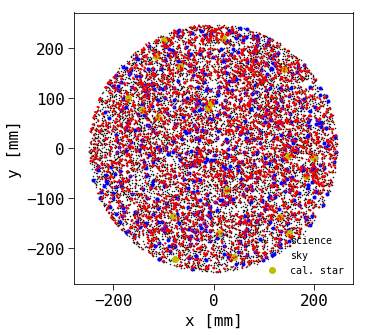

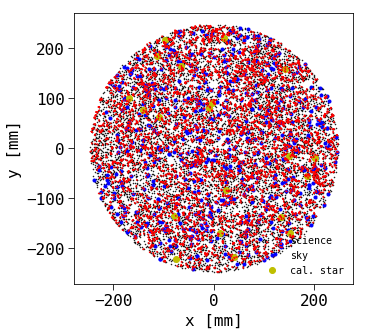

In [16]:
from scipy.spatial.distance import cdist


# find collision pairs
fiber_collision_radius = 1.
        
# I am sure this code cound be massively optimized by subdeviding the focal plane
ENABLE_COLLISION_AVOIDANCE = True

collision_pairs = OrderedDict()

if ENABLE_COLLISION_AVOIDANCE:
    for pid,(pointing_RA,pointing_DEC) in pointings.items():

        targets = target_fplane_pos[pid]
        tclasses = [class_dict[tid] for tid in target_fplane_pos[pid]]

        f = plt.figure(figsize=[5,5])
        plt.subplot()
        txx = np.array( [t[0] for tid, t in targets.items()] )
        tyy = np.array( [t[1] for tid, t in targets.items()] )

        _ii_sci = list( map( lambda x : x.startswith('sci') , tclasses ) )
        _ii_sky = list( map( lambda x : x.startswith('sky') , tclasses ) ) 
        _ii_cal = list( map( lambda x : x.startswith('cal') , tclasses ) )


        plt.plot(txx[_ii_sci],tyy[_ii_sci],'.', ms=1, label='science')
        plt.plot(txx[_ii_sky],tyy[_ii_sky],'b.' , label='sky')
        plt.plot(txx[_ii_cal],tyy[_ii_cal],'yo' , label='cal. star')


        N = len(ID)
        points = list( zip(txx,tyy) )
        Y = cdist( points[:N], points[:N] )

        # any target separation that is smaller than 2 x the collision radius will be flagged a s collision
        cc = Y <= (fiber_collision_radius*2.) 
        ncoll = int( (np.sum(cc.flatten()) - N)/2. )

        print ("Pointing {}: Found  {:d} collision pairs.".format( pid, ncoll  ))

        # identify collision pairs
        collision_pairs[pid] = []
        # array of indices
        ii = np.arange(N)
        for i in range(cc.shape[0]):
            x1,y1 =  txx[i], tyy[i]
            # only iterate over the indeces that are colliding and the upper diagonal in the collision matrix
            jj = ii[ cc[i,:] * ii > i ] 
            for j in jj: 
                if cc[i,j]:
                    x2,y2 =  txx[j], tyy[j]
                    collision_pairs[pid].append([(ID[i],x1,y1),(ID[j],x2,y2)])


        for cp in collision_pairs[pid]:
            plt.plot([cp[0][1],cp[1][1]],[cp[0][2],cp[1][2]],'r-')


        plt.axis('equal')
        l = plt.legend()
        l.draw_frame(False)
        plt.xlabel("x [mm]")
        plt.ylabel("y [mm]")
        plt.xlim([-15,15])

# Invert visibilities

In [17]:
# Compute a few statistics:
# Number of rachable targets by type and
# number of cobras that can observe any target.
def invert_vis(visibilities):
    """
    Invert visibility map, i.e. for each cobra list the observable targets
    """
    ivisibilities = OrderedDict()
    for pid in visibilities:
        cnt = 0
        ivisibilities[pid] = OrderedDict()
        for v in visibilities[pid]:
            t = v
            cc = visibilities[pid][v]

            for c in cc:
                if c in ivisibilities[pid]:
                    ivisibilities[pid][c].append(v)
                else:
                    ivisibilities[pid][c] = [v]

    return ivisibilities

ivisibilities = invert_vis(visibilities)           

In [18]:
for pid in visibilities:
    print("Pointing {}".format(pid))
    nsci_observable = 0
    ncal_observable = 0
    nsky_observable = 0

    for tid,v in visibilities[pid].items():
        if len(v) > 0:
            if class_dict[tid][:3] == 'cal':
                ncal_observable += 1
            elif class_dict[tid][:3] == 'sky':
                nsky_observable += 1
            elif class_dict[tid][:3] == 'sci':
                nsci_observable += 1
            #break


    print("{} targets positions in total.".format(sum(ii_sci) ))
    print("{} cal. targets in total.".format(sum(ii_cal) ))
    print("{} sky positions in total.".format(sum(ii_sky) ))
    print("{} cobras have at least one target in reach.".format(len(ivisibilities[pid])))
    print("{} science targets\n{} calibration targets, \
    and \n{} sky positions are in reach of at least one cobra.".format(nsci_observable, ncal_observable, nsky_observable))  
    print("")

Pointing A
12531 targets positions in total.
20 cal. targets in total.
567 sky positions in total.
2349 cobras have at least one target in reach.
8110 science targets
10 calibration targets,     and 
362 sky positions are in reach of at least one cobra.

Pointing B
12531 targets positions in total.
20 cal. targets in total.
567 sky positions in total.
2352 cobras have at least one target in reach.
8121 science targets
11 calibration targets,     and 
360 sky positions are in reach of at least one cobra.



# Execute netflow

In [19]:
# Define the cost function
from numpy import inf

cost_dict = {}
# For each target class we define the cost 
# of non-observation and non-completion as 
# a two-tuple. The cost of non-completion 
# is typically larger as partial completion 
# of objects should be avoided.
cost_dict['sci_P01'] = (1e4,1e9)


# For the calibration objects we only define the cost
# of non-observation as calibration targets only *need* to be visited once.
# Note: The can of course be visited many times. But
# for the calibration objects the real constraint is to have 
# at least N out of M observed in each exposure.
# There is no requirement to revisit a specific calibration target.
cost_dict['cal_P01'] = 1e12
cost_dict['sky_P01'] = 1e12

# Here we add higher cost to later visits. Ther should be one entry per visit.
cost_dict['visits'] = OrderedDict()
for i, pid in enumerate(pointings):
      cost_dict['visits'][pid] = i*10.

# Here we discourage large cobra moves. The example here is a simple
# linear function cost = A * move_distance 
# where the parameter A controls how quickly the cost increases as funciton of distance.
#A = 250.
A = 0.
cost_dict['cobra_move'] = lambda d : d*A  


# Here we define how at least many objects out of each class we want observed.
supply_dict = {}
# By setting science object to inf, we say we want them all.
supply_dict['sci_P01'] = inf

# need one calibration star per exposure
supply_dict['cal_P01'] = 0 # force exactly 40
# need one sky positions per exposure
supply_dict['sky_P01'] = 0 # force exactly 240


In [20]:
# Build the survey plan graph.

from numpy import inf
from pfs_netflow.survey_plan import buildSurveyPlan
from pfs_netflow.plotting import plotSurveyPlan


COBRAS = []




# intermediate example
RMAX = 150.
CENTER = [0.,0.]
name="intermediate"

# do them all!
RMAX = 25.
CENTER = [-0.,0.]
name="small"

# good very minimal example
RMAX = 10.
CENTER = [-0.,0.]
name="tinytiny"

# do them all!
RMAX = 300.
CENTER = [-0.,0.]
name="all"

# check for changing visibility
RMAX = 10.
CENTER = [7.,-12.]
name="tiny"



print("Creating graph ...")


# for per-ponting list of targets, build
# single list of targets with multiple entries for the focal plane positions
targets = OrderedDict()
for pid in target_fplane_pos:
    tt = target_fplane_pos[pid] 
    for tid in tt:
        x,y = tt[tid]
        if not tid in targets:
             targets[tid] = OrderedDict()
        targets[tid][pid] = (x,y)
        


# build the survey plan graph
g = buildSurveyPlan(cobras, targets, nreqv_dict, visibilities, class_dict,\
                    cost_dict, supply_dict, RMAX, CENTER=(0.,0.), COBRAS=[])


#plotFP(cobras,dots,target_fplane_pos,maxx=20.,maxy=20.)
#plotSurveyPlan(g)

print("Done.")

for c in g.sciTargetClasses:
    
    nsci = 0
    nsci_reachable = 0
    for t in g.sciTargetClasses[c].targets.values():
        if t.outarcs != []:
            nsci += 1
            nsci_reachable += 1
        
    print("Number of targets in {} is {}.".format(c, nsci ) )
    print("Number of observable targets in {} is {}.".format(c, nsci_reachable ) )
    

ncal = 0
ncal_reachable = 0
for t in g.calTargetClasses['TClass_cal_P01_vA'].targets.values():
    if t.outarcs != []:
        ncal += 1
        ncal_reachable += 1
print("Number of calibration stars: {}".format(ncal) )
print("Number of observable calibration stars: {}".format( ncal_reachable )) 
            

nsky = 0
nsky_reachable = 0
for t in g.calTargetClasses['TClass_sky_P01_vA'].targets.values():
    if t. outarcs != []:
        nsky += 1
        nsky_reachable += 1
print("Number of sky positions: {}".format(nsky) )
print("Number of observable sky positions: {}".format(nsky_reachable) )

#if RMAX == 10. and False:
#    plotSurveyPlan(g)
    

Creating graph ...
buildSurveyPlan
Done.
Number of targets in TClass_sci_P01 is 19.
Number of observable targets in TClass_sci_P01 is 19.
Number of calibration stars: 0
Number of observable calibration stars: 0
Number of sky positions: 1
Number of observable sky positions: 1


In [21]:
# build the LP problem
from pfs_netflow.lp import buildLPProblem, computeStats, solve
from pulp import LpStatus, value
import time


def setflows(g,flows):
    for a in g.arcs.values():
        k = '{}={}'.format(a.startnode.id,a.endnode.id)
        if k in flows:
            a.flow = value(flows[k])


    
NCobras = len(g.cobras)
NSciTargets = len(g.sciTargets)
NCalTargets = len(g.calTargets)

maxSeconds = 600.

NVISITS = len( g.visits )

summary = ""
summary += pp("NVISITS = {}".format(NVISITS))
summary += pp("Searching optimal strategy to observe in ")
summary += pp(" {} visits".format(NVISITS))
summary += pp(" {} science targets".format(NSciTargets))
summary += pp(" {} calib. targets".format(int(NCalTargets/NVISITS) ))
summary += pp(" {} cobras".format(NCobras))
#summary += pp("Will stop in any case after {} s.".format(maxSeconds))


summary += pp("num nodes: {}".format(len(g.nodes)))
summary += pp("num edges: {}".format(len(g.arcs)))

#visualizeSurveyPlan(g)

summary += pp("Building LP problem ...")
start_time = time.time()
prob, flows, cost = buildLPProblem(g, cat='Integer')
#prob, flows, cost = buildLPProblem(g, cat='Continuous')
time_to_build = time.time() - start_time
summary += pp("Time to build model: {:.4e} s".format(time_to_build))

__ = prob.writeMPS("pfi_cosmo_{}_{}_visits_rand_nreq.mps".format(name,NVISITS), rename=1)

NVISITS = 2
Searching optimal strategy to observe in 
 2 visits
 19 science targets
 1 calib. targets
 6 cobras
num nodes: 83
num edges: 128
Building LP problem ...
Building cost equation ...
 Time to completion: 0.01 s
Time to build model: 8.6288e-03 s


In [22]:
import pulp

ENABLE_COLLISION_AVOIDANCE = True

def compute_collision_flow_pairs(g, collision_pairs):
    """
     Identifiy which flow variables correspond to which collision pairs.

     This is not a nice piece of code, mostly because we need to treat science and
     calibrations targets differently
     What we do:
     Loop over all collision pairs (science - science, science - cal, cal - cal)
      then for each visit
       look if they are actually part of the graph (in case we are dealing with a subregaion of the focal plane only we might ignore them)
       identify the input flow arc (ther can be only one) for each of the two targets in the pair
       add the flow pairs to a list
     loop over all flow pairs and add a constraint equation
    """ 
    flow_pairs = []

    for pid in collision_pairs:
        for cp in collision_pairs[pid]:

            for visit in g.visits:
                tid1 = cp[0][0]
                tid2 = cp[1][0]

                tvid1 = "T_{}_v{}".format(cp[0][0],visit)
                tvid2 = "T_{}_v{}".format(cp[1][0],visit)

                # science targets have targetVisit nodes
                # calibrations targets do not (there ais a doublicate for each visits)
                if tvid1 in g.calTargets:
                    f1id = g.calTargets[tvid1].inarcs[0].id
                elif tvid1 in g.targetVisits:
                    f1id = g.targetVisits[tvid1].inarcs[0].id
                else:
                    continue # this target is not part of the problem, probably did not survive RMAX cut

                if tvid2 in g.calTargets:
                    f2id = g.calTargets[tvid2].inarcs[0].id
                elif tvid2 in g.targetVisits:
                    f2id = g.targetVisits[tvid2].inarcs[0].id
                else:
                    continue # this target is not part of the problem, probably did not survive RMAX cut


                flow_pairs.append([f1id, f2id])
    return flow_pairs
  
if ENABLE_COLLISION_AVOIDANCE:
    flow_pairs = compute_collision_flow_pairs(g, collision_pairs)
    print("Adding {} collision avoidance constraints.".format(len(flow_pairs)))              
    for fp in flow_pairs:
        prob += pulp.lpSum( [ flows[ fp[0] ], flows[ fp[1] ] ] ) <= 1.

__ = prob.writeMPS("pfi_cosmo_{}_{}_visits_rand_nreq_colldetect.mps".format(name,NVISITS), rename=1)

Adding 36 collision avoidance constraints.


In [23]:
from numpy import random

# solve it!
#maxSeconds=2400.

random.seed(42)

# Solve problem!
summary += pp("Solving LP problem ...")
start_time = time.time()


#status = solve(prob, maxSeconds=maxSeconds)
status = solve(prob, solver="GUROBI")


time_to_solve = time.time() - start_time
summary += pp("Solve status is [{}].".format( LpStatus[status] ))
summary += pp("Time to solve: {:.4e} s".format(time_to_solve))


Solving LP problem ...
Optimize a model with 113 rows, 129 columns and 336 nonzeros
Variable types: 1 continuous, 128 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+12]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+06]
  RHS range        [1e+00, 2e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 1.2e+10
Presolve removed 113 rows and 129 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 2: 110040 1.2e+10 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.100400000000e+05, best bound 1.100400000000e+05, gap 0.0000%
Gurobi status= 2
Solve status is [Optimal].
Time to solve: 3.3071e-02 s


In [24]:
stats = computeStats(g, flows, cost)

summary += pp("{} = {}".format('Value of cost function',value(stats['cost']) ) )
summary += pp("[{}] out of {} science targets get observed.".format(int(stats['NSciObs']) ,NSciTargets) )
summary += pp("For {} out of these all required exposures got allocated.".format(stats['NSciComplete']))  
summary += pp("Per target class completion:")
                                                            
summary += pp("   {:15s} {:10s} {:10s} {:10s}".format('class', 'total', 'observed', 'completed') )
for tc,compl in stats['completion'].items():
    summary += pp("   {:15s} {:10d} {:10d} {:10d}".format(tc, compl['total'],compl['observed'],compl['completed']))                                                                       
    #print(tc, compl)                                                                  
summary += pp("{} targets get sent down the overflow arc.".format(stats['Noverflow']))
summary += pp("{} out of {} cobras observed a target in one or more exposures.".format(stats['Ncobras_used'], NCobras ))
summary += pp("{} cobras observed a target in all exposures.".format(stats['Ncobras_fully_used']))

setflows(g,flows)

Value of cost function = 110040.0
[8] out of 19 science targets get observed.
For 8 out of these all required exposures got allocated.
Per target class completion:
   class           total      observed   completed 
   TClass_sci_P01          19          8          8
11 targets get sent down the overflow arc.
5 out of 6 cobras observed a target in one or more exposures.
3 cobras observed a target in all exposures.


In [25]:
# test if really no colliding targets were observed
# This needs to be added to the survey plan and buildLPProblem methods.
#
import pulp
from pulp import value


flow_pairs = compute_collision_flow_pairs(g, collision_pairs)
 
NCOLL = 0
for fp in flow_pairs:
    
    if value( flows[ fp[0] ] ) > 0. and value( flows[ fp[1] ] ) > 0.:
        #print("{} {} in collision".format(fp[0],fp[1]))
        NCOLL += 1
                             
print("Detected {} collisions".format(NCOLL))

Detected 0 collisions


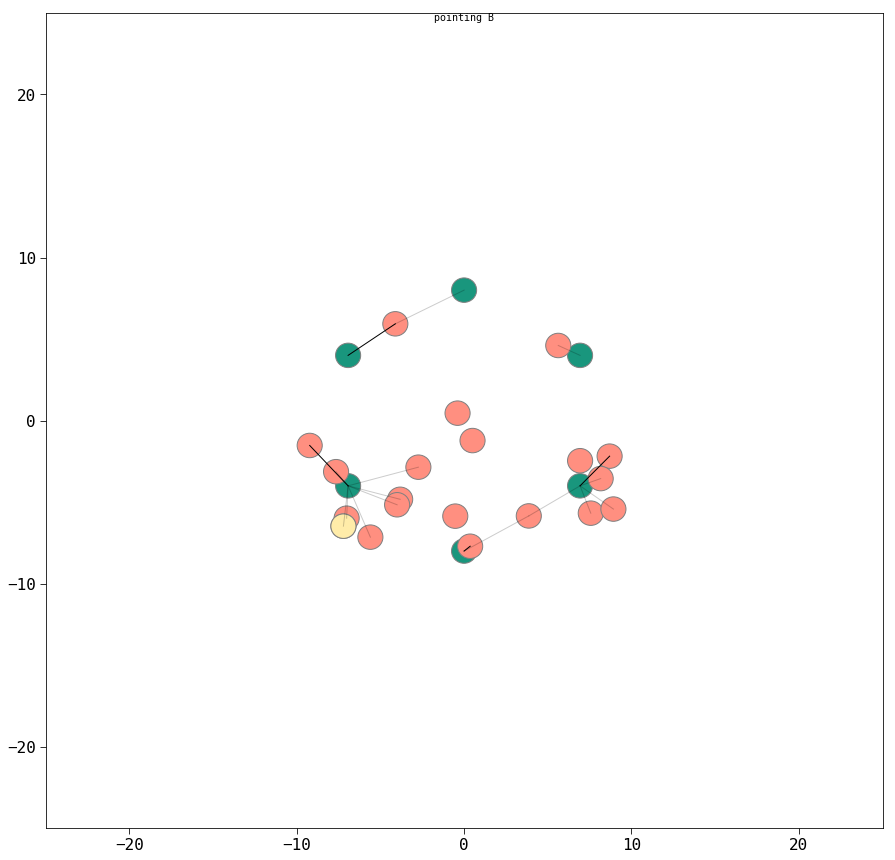

In [32]:
from pfs_netflow.plotting import plotFocalPlane
def setflows(g,flows):
    for a in g.arcs.itervalues():
        k = '{}={}'.format(a.startnode.id,a.endnode.id)
        if flows.has_key(k):
            a.flow = value(flows[k])
            
if True:
    plotFocalPlane(g, pid='B', W=50)
    #plotSurveyPlan(g)

# prepare Cobra/Target pairs to run trajectory collision detection

In [ ]:
plotSurveyPlan(g)

In [ ]:

visit = 0
 
# initialize assigment list with Null
# as required by the collision simulator code.
assignments = OrderedDict()
for c in g.cobras.itervalues():
    assignments[c.id] = 'Null'

# Now find which cobras have been assigned to which targets. 
# Loop over all targetVisit to CobraVisit arcs.Filter for those that correspond to the current visit.
for a in filter(lambda x : x.visit == visit, g.targetVisitToCobraVisitArcs.itervalues()):
    
    if a.flow > 0.:
        t = a.startnode.target
        c = a.endnode.cobra 
        assignments[c.id] = t.id
        
for cid,tid in assignments.iteritems():
    print("{:6s} observes {:10s}".format(cid, tid))


In [ ]:
# feed to collision code
import numpy as np
import time as time

import sys
sys.path.append("/Users/mxhf/work/MPE/pfs/src/ics_cobraOps/python")

import ics.cobraOps.plotUtils as plotUtils
import ics.cobraOps.targetUtils as targetUtils

from ics.cobraOps.Bench import Bench
from ics.cobraOps.CobrasCalibrationProduct import CobrasCalibrationProduct
from ics.cobraOps.CollisionSimulator import CollisionSimulator
from ics.cobraOps.DistanceTargetSelector import DistanceTargetSelector
from ics.cobraOps.RandomTargetSelector import RandomTargetSelector

# Create the bench instanceroduct)
#bench = Bench(layout="full", calibrationProduct=calibrationP
cpos = [ [ complex(g.cobras[cid].x , g.cobras[cid].y) ] for cid in assignments]
bench = Bench(cobraCenters=np.array( cpos ))

print("Number of cobras:", bench.cobras.nCobras)

In [ ]:

# Calculate the total number of targets based on the bench properties
    medianPatrolAreaRadius = np.median(bench.cobras.rMax)

    
    nTargets = int(np.ceil(density * (bench.radius / medianPatrolAreaRadius) ** 2))
    
    # Calculate the uniformly distributed target positions
    ang = 2 * np.pi * np.random.random(nTargets)
    radius = bench.radius * np.sqrt(np.random.random(nTargets))
    targetPositions = bench.center + radius * np.exp(1j * ang)
    
    return TargetGroup(targetPositions)

In [ ]:
# Generate the targets
targets = targetUtils.generateRandomTargets(targetDensity, bench)
print("Number of simulated targets:", targets.nTargets)

# Select the targets
selector = DistanceTargetSelector(bench, targets)
selector.run()
selectedTargets = selector.getSelectedTargets()

# Simulate an observation
start = time.time()
simulator = CollisionSimulator(bench, selectedTargets)
simulator.run()
print("Number of cobras involved in collisions:", simulator.nCollisions)
print("Number of cobras unaffected by end collisions: ", simulator.nCollisions - simulator.nEndPointCollisions)
print("Total simulation time (s):", time.time() - start)

# Statistics on cobra motion

In [ ]:

# array of all distances for all possible target/cobra pairs
dd =  np.array( [ a.d for a in g.targetVisitToCobraVisitArcs.itervalues()] )
# array of flows for all possible target/cobra pairs
ff =  np.array( [ value(flows[a.id]) for a in g.targetVisitToCobraVisitArcs.itervalues()] )

# caclulate mean cobra move distance
ii = ff > 0.
mn_movedist = np.mean( dd[ii] )
min_movedist = np.min( dd[ii] )
max_movedist = np.max( dd[ii] )
std_movedist = np.std( dd[ii] )

print("mn_movedist =  {:.3f}mm".format(mn_movedist) )
print("min_movedist = {:.3f}mm".format(min_movedist) )
print("max_movedist = {:.3f}mm".format(max_movedist) )
print("std_movedist = {:.3f}mm".format(std_movedist) )


cm = np.sum([ a.cost * value(flows[a.id]) for a in g.targetVisitToCobraVisitArcs.itervalues() ])

print("cost from moves = {}".format(cm) )


plt.hist( dd[ii] )
plt.xlabel("d[mm]")
plt.ylabel("N")

# Performace evaluations observed targets vs. number of visits

In [ ]:
nsci_observed_total = 0


with open("nwf_results_nvisits{}_early_obs2.txt".format(NVISITS), 'w') as f:
    s  = "# algorithm: {}\n".format("netflow")
    s += "# total number of vistis: {}\n".format(NVISISTS)

    s += "# total number of observable science targets: {}\n".format(nsci_observable)
    s += "# total number of observable cal. targets: {}\n".format(ncal_observable)
    s += "# total number of observable sky positions: {}\n".format(nsky_observable)
    s += "{:3s} {:5s} {:5s} {:5s} {:5s}\n".format("V", "nsci", "ncal", "nsky", "nsci_total")
    f.write(s)

    for visit in g.visits:
        print("Visit {}".format(visit))
        nsci = 0
        ncal = 0
        nsky = 0
        for a in g.arcs.itervalues():
            n1,n2 = a.startnode,a.endnode

            if a.flow > 0.:
                #print n1,n2, a.flow, n2.visit
                #print type(n2) == dm.CobraVisit , n2.visit == visit , type(n1) == dm.TargetVisit
                #break
                if type(n2) == dm.CobraVisit and n2.visit == visit and type(n1) == dm.TargetVisit:
                        nsci += 1
                        nsci_observed_total += 1
                if type(n2) == dm.CobraVisit and n2.visit == visit and type(n1) == dm.CalTarget:
                        try:
                            if class_dict[ n1.id[2:-3] ][:3] == "sky":
                                nsky += 1

                            else:
                                ncal += 1 
                        except:
                            pass

        s = "{:3d} {:5d} {:5d} {:5d} {:5d}\n".format(visit, nsci, ncal, nsky, nsci_observed_total)
        f.write(s)
        
        print(" Observed {} science targets, {} calibration targets and {} sky positions.".format(nsci, ncal, nsky))
        print(" Observed {} science targets in total.".format(nsci_observed_total))
        #print("")


In [ ]:
g.targetToTargetVisitArcs

value( flows['T_C000996->T_C000996_v0'.replace("->","=")] )

In [ ]:
from pfs_netflow.plotting import plotFocalPlane
def setflows(g,flows):
    for a in g.arcs.itervalues():
        k = '{}={}'.format(a.startnode.id,a.endnode.id)
        if flows.has_key(k):
            a.flow = value(flows[k])
            
if False:
    from pfs_netflow.plotting import plotFocalPlane

    plotFocalPlane(g, visit=1, W=20)
    plotSurveyPlan(g)

In [ ]:
nsci = sum( [class_dict[t][:3] == "sci" for t in targets] )
ncal = sum( [class_dict[t][:3] == "cal" for t in targets] )
nsky = sum( [class_dict[t][:3] == "sky" for t in targets] )

sum( [class_dict[t][:3] == "cal" for t in targets] )


print("{} targets positions in total.".format( nsci ))
print("{} cal. targets in total.".format( ncal ))
print("{} sky positions in total.".format( nsky ))


# performance comparison ETS vs. netflow

In [ ]:
from astropy.io import ascii

nwf_results_nvisits = {}
#nwf_results_nvisits[12] = ascii.read("nwf_results_nvisits12.txt")
#nwf_results_nvisits[12] = ascii.read("nwf_results_nvisits12.txt")
nwf_results_nvisits[10] = ascii.read("nwf_results_nvisits10_early_obs1.txt")
#nwf_results_nvisits[9] = ascii.read("nwf_results_nvisits9.txt")
#nwf_results_nvisits[8] = ascii.read("nwf_results_nvisits8.txt")
#nwf_results_nvisits[7] = ascii.read("nwf_results_nvisits7.txt")
#nwf_results_nvisits[6] = ascii.read("nwf_results_nvisits6.txt")
#nwf_results_nvisits[5] = ascii.read("nwf_results_nvisits5.txt")
#nwf_results_nvisits[4] = ascii.read("nwf_results_nvisits4.txt")
#nwf_results_nvisits[3] = ascii.read("nwf_results_nvisits3.txt")
#nwf_results_nvisits[2] = ascii.read("nwf_results_nvisits2.txt")

ets_results = {}
ets_results["draining_closest"] = ascii.read("ets_results_draining_closest.txt")
ets_results["draining"] = ascii.read("ets_results_draining.txt")
ets_results["naive"] = ascii.read("ets_results_naive.txt")
ets_results["new"] = ascii.read("ets_results_new.txt")

#ascii.read("ets_results_draining_closest.txt",format

f = plt.figure(figsize=[8,8])

for alg in ets_results:
    plt.plot(ets_results[alg]['V']+1, ets_results[alg]['nsci_total'],'o-', label=alg)

#for nvisits in nwf_results_nvisits:
#    plt.plot(nwf_results_nvisits[nvisits]['V']+1, nwf_results_nvisits[nvisits]['nsci_total'],'ks-', label=alg, color='grey', ms=8)

nvisits = 10
plt.plot(nwf_results_nvisits[nvisits]['V']+1, nwf_results_nvisits[nvisits]['nsci_total'],'ks-', label="netflow", color='grey', ms=8)

l = plt.legend()
l.draw_frame(False)

plt.axhline(nsci_observable,ls=":",c='k')
plt.text(1,nsci_observable+50,"max # science targets observable".format(nsci_observable),ha='left',va='bottom')
plt.ylabel("# science targets observed")
plt.xlabel("visit")
plt.ylim([500,8200])

# New & auxiliary stuff

In [ ]:
if False:
    # test output for other solvers
    # build problem save to MPS
    import time


    summary += pp("Building LP problem ...")
    start_time = time.time()
    #prob, flows, cost = buildLPProblem(g, cat='Integer')
    prob, flows, cost = buildLPProblem(g, cat='Continuous')
    time_to_build = time.time() - start_time
    summary += pp("Time to build model: {:.4e} s".format(time_to_build))

    prob.writeMPS("pfi_cosmo_{}_{}_visits_rand_nreq.mps".format(name,NVISITS), rename=1)

In [ ]:
RSEP = 5.

if RSEP > 0.:
    print("Finding collision pairs ...")
    tt = np.array( [t for t in g.targets.itervalues()] )
    tt_xy = [ (g.targets[t].x,g.targets[t].y) for t in g.targets]

    N = len(tt)

    from scipy.spatial import distance
    # calculat collisions from all pairwise separations
    colls = distance.cdist(tt_xy, tt_xy, 'euclidean') < RSEP
    # set lower diagonal to False, if we know that A collides with B already
    # then we don't need to take into account that B collides with A
    colls[ np.tril_indices(N) ] = False 

    coll_pairs = []
    for i,t1 in enumerate(tt):
        for t2 in tt[ colls[i] ].tolist():
            coll_pairs.append([t1,t2])
            #print t1.id,t2.id

    print( "Found {} collision pairs.".format(len( coll_pairs )) )

    #for tid,t in tt:
    #    prob += pulp.lpSum( [ flows['{}={}'.format(a.startnode.id,a.endnode.id)] for a in t.outarcs]) <= 1
    
    

In [ ]:
i = 0

t1,t2 = coll_pairs[i]

print type(t1) == SciTarget
print type(t1) == CalTarget

t2.outarcs

In [ ]:
# Sanity check, make sure all flows are integer:
allflows = []
for a in g.arcs.itervalues():
    k = '{}={}'.format(a.startnode.id,a.endnode.id)
    if flows.has_key(k):
        allflows.append(value(flows[k]))

print("All flows are: integer {}".format(all( unique(allflows)%1 == 0 )))


In [ ]:
if True:
    # plot solution
    for a in g.arcs.itervalues():
        k = '{}={}'.format(a.startnode.id,a.endnode.id)
        if flows.has_key(k):
            a.flow = value(flows[k])
    plotSurveyPlan(g)
    #return g, stats, time_to_build, time_to_solve, status, prob, flows, cost, summary

In [ ]:
if False:
    def rescue_code(function):
        import inspect
        get_ipython().set_next_input("".join(inspect.getsourcelines(function)[0]))

    rescue_code(buildSurveyPlan)

In [ ]:
!open .

# Old collision detection code

In [ ]:
# find collision pairs

`
from scipy.spatial.distance import cdist
fiber_collision_radius = 1.


f = plt.figure(figsize=[20,20])
plt.subplot()


txx = np.array( [t.x for tid, t in g.targets.iteritems()] )
tyy = np.array( [t.y for tid, t in g.targets.iteritems()] )

_ii_sci = map( lambda x : x.startswith('sci') , tclasses )
_ii_sky = map( lambda x : x.startswith('sky') , tclasses )
_ii_cal = map( lambda x : x.startswith('cal') , tclasses )


plt.plot(txx,tyy,'.', ms=1, label='science')
#plt.plot(txx[_ii_sky],tyy[_ii_sky],'b.' , label='sky')
#plt.plot(txx[_ii_cal],tyy[_ii_cal],'yo' , label='cal. star')


N = len(g.targets)
points = zip(txx,tyy)
Y = cdist( points[:N], points[:N] )



# any target separation that is smaller than 2 x the collision radius will be flagged a s collision
cc = Y <= (fiber_collision_radius*2.) 

ncoll = int( (np.sum(cc.flatten()) - N)/2. )

print ("Found  {:d} collision pairs.".format( ncoll  ))


# identify collision pairs
collision_pairs = []
# array of indices
ii = np.arange(N)
for i in range(cc.shape[0]):
    x1,y1 =  txx[i], tyy[i]
    # only iterate over the indeces that are colliding and the upper diagonal in the collision matrix
    jj = ii[ cc[i,:] * ii > i ] 
    for j in jj: 
        if cc[i,j]:
            x2,y2 =  txx[j], tyy[j]
            collision_pairs.append([(ID[i],x1,y1),(ID[j],x2,y2)])
            
            

            
for cp in collision_pairs:
    plt.plot([cp[0][1],cp[1][1]],[cp[0][2],cp[1][2]],'r-')
    #plt.plot(txx[ii_cal],tyy[ii_cal],'yo' , label='cal. star')

print len(collision_pairs)

plt.axis('equal')
l = plt.legend()
l.draw_frame(False)
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
plt.xlim([-50,50])

cc = Y < 6.
print sum(cc.flatten())